In [5]:
import torch
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from make_dataset import DataGen
import matplotlib.pyplot as plt
import os
import pandas as pd
import torchvision
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
import cv2

In [6]:
## TODO: get list of image paths and labels
img_labels = pd.read_csv('data/per_scan_data.csv')

In [7]:
img_labels.head()

,scan_name,scan_number,folder_name,patient_id,eye_side,status
0,064_OS_6_GA_6x6_SSOCT_1_168.jpg,168,064_OS_6_GA_6x6_SSOCT_1,64,left,False
1,064_OS_6_GA_6x6_SSOCT_1_202.jpg,202,064_OS_6_GA_6x6_SSOCT_1,64,left,True
2,064_OS_6_GA_6x6_SSOCT_1_397.jpg,397,064_OS_6_GA_6x6_SSOCT_1,64,left,False
3,064_OS_6_GA_6x6_SSOCT_1_204.jpg,204,064_OS_6_GA_6x6_SSOCT_1,64,left,True
4,064_OS_6_GA_6x6_SSOCT_1_44.jpg,44,064_OS_6_GA_6x6_SSOCT_1,64,left,False


In [8]:
# Open the file with all images
all_slices_path = r'/Volumes/fsmresfiles/Ophthalmology/Mirza_Images/AMD/dAMD_GA/all_slices_3'
all_slices = os.listdir(all_slices_path)

# collect all images 
all_imgs = [item for item in all_slices if item.endswith('.jpg')]
print(len(all_imgs))

21500


In [9]:
def find_labels(image_list):
    labels = []
    name_column = 'scan_name'
    for image_name in image_list:
        found_row = img_labels[img_labels[name_column] == image_name]
        if found_row['status'].item() == True:
            labels.append(1)
        else: 
            labels.append(0)
    return labels


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False
    
nr_filters = model.fc.in_features
model.fc = nn.Linear(nr_filters, 1)
model = model.to(device)

In [11]:
train_image_names, val_image_names, test_image_names = torch.utils.data.random_split(all_imgs, [15000,3250,3250])
train_set_labels = find_labels(train_image_names)
val_set_labels = find_labels(val_image_names)
test_set_labels = find_labels(test_image_names)

In [12]:
train_tensors = []
val_tensors = []
test_tensors = []

In [13]:
train_data = []
for i in range(len(train_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+train_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    train_data.append([temp_img, train_set_labels[i]])
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

val_data = []
for i in range(len(val_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+val_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    val_data.append([temp_img, val_set_labels[i]])
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=32)

test_data = []
for i in range(len(test_image_names)):
    temp_img = torchvision.io.read_image(all_slices_path+"/"+test_image_names[i])
    temp_img = temp_img.repeat(3,1,1)
    test_data.append([temp_img, test_set_labels[i]])
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=32)

torch.Size([3, 1536, 500])


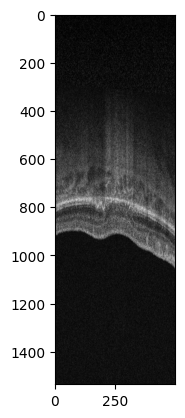

In [15]:
#img = cv2.imread(all_slices_path+"/"+train_image_names[0])
# test = torchvision.io.read_image(all_slices_path+"/"+train_image_names[1])
# test = test.repeat(3,1,1)
plt.imshow(test_data[0][0].permute(1,2,0))
print(test_data[0][0].size())
plt.show()

In [ ]:
criterion = BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## start training
num_epochs = 10
print("starting training: ")
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.float().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects.double() / len(train_loader)

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    

starting training: 
Epoch 0/9
----------
